# dSprites Warmup

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from pathlib import Path
import requests
import pickle
import gzip

In [2]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(torch.cuda.is_available())

True


## Load data

In [3]:
dataset_zip = np.load('/home/jupyter/causalML/tutorials/data/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle=True, encoding='bytes')

imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

In [4]:
metadata.keys()

dict_keys([b'date', b'description', b'version', b'latents_names', b'latents_possible_values', b'latents_sizes', b'author', b'title'])

In [5]:
# Define number of values per latents and functions to convert to indices
latents_sizes = metadata[b'latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
    return np.dot(latents, latents_bases).astype(int)

def sample_latent(size=1):
    samples = np.zeros((size, latents_sizes.size))
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)
    return samples

In [6]:
# Helper function to show images
def show_images_grid(imgs_, num_images=25):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
    else:
        ax.axis('off')

In [22]:
SAMPLE_SIZE = 60000 # 60000
latents_sampled = sample_latent(size=SAMPLE_SIZE)
# latents_sampled[:, 1] = 1

# Select images
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Show images
# show_images_grid(imgs_sampled)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(imgs_sampled.astype('float32'), latents_sampled[:,1].astype('int64'), 
                                                    test_size=0.1667, random_state=42)
x_train, y_train, x_test, y_test = map(
    torch.tensor, (x_train, y_train, x_test, y_test)
)

## Build model

In [29]:
BATCH_SIZE = 128
IMAGE_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 0.05
MOMENTUM = 0.9

In [30]:
def get_data(train_ds, test_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(test_ds, batch_size=bs * 2),
    )

def preprocess(x, y):
    return x.view(-1, 1, IMAGE_SIZE, IMAGE_SIZE).to(dev), y.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
    
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)
    
def fit(epochs, model, loss_func, opt, train_dl, test_dl):
    # loop through epochs
    for epoch in range(epochs):
        # loop through all batches, adjusts weights via opt and loss_func
        model.train() # put model in training mode (for things like dropout)
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        # calculate validation loss
        model.eval() # put model in evaluation mode (for things like dropout)
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in test_dl]
            )
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, test_loss)

In [31]:
train_ds = TensorDataset(x_train, y_train)
test_ds = TensorDataset(x_test, y_test)

train_dl, test_dl = get_data(train_ds, test_ds, BATCH_SIZE)
train_dl = WrappedDataLoader(train_dl, preprocess)
test_dl = WrappedDataLoader(test_dl, preprocess)

In [32]:
class ModelDSprite(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*16*16, 64)
        self.fc2 = nn.Linear(64, 3)        
    def forward(self, x):
        # 32 x 64 x 64
        x = F.relu(self.conv1(x))
        # 32 x 32 x 32
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        # 64 x 32 x 32
        x = F.relu(self.conv2(x))
        # 64 x 16 x 16
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        x = x.view(-1, 64*16*16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)        

In [33]:
# %%time

model = ModelDSprite()
model.to(dev)

loss_func = F.cross_entropy
opt = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

fit(EPOCHS, model, loss_func, opt, train_dl, test_dl)

# 0 1.0205792663121696
# 1 1.0181344623471278
# 2 1.0312850714516482
# 3 0.9798258404640217
# 4 0.9714416380620818
# 5 0.9638791082859325
# 6 1.026337376667771
# 7 0.6992057580109764
# 8 0.37132105935671117
# 9 0.13169585563014494
# CPU times: user 15min 12s, sys: 5min 55s, total: 21min 7s
# Wall time: 7min 10s

0 0.9742710431965083
1 0.9754475372787762
2 0.9618331156499718
3 0.7237962132643471
4 0.2568916223736149
5 0.039183057822291555
6 0.013970756335297577
7 0.011966080526796919
8 0.01564020741985315
9 0.004673301935988506
10 0.00551016409068531
11 0.002877418363012092
12 0.002784902598635122
13 0.002708173279665966
14 0.002717289106368756


In [34]:
def count_correct(y_pred, y_truth):
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_truth).float().sum()

model.eval()
cc = 0
tot = 0
with torch.no_grad():
    for xb, yb in test_dl:
        y_pred = model(xb)
        tot += len(y_pred)
        cc += count_correct(y_pred, yb)
accuracy = cc/tot
print(accuracy)

tensor(0.9993, device='cuda:0')


0    0


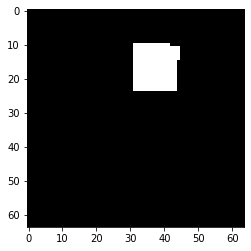

In [60]:
ind = np.random.choice(range(len(y_test)))
pred = model(x_test[ind].view(-1,1,IMAGE_SIZE,IMAGE_SIZE).to(dev))
pred = torch.argmax(pred,dim=1)
print(pred[0].item(), '  ', y_test[ind].item())
plt.imshow(x_test[ind].reshape((IMAGE_SIZE, IMAGE_SIZE)), cmap="gray")
plt.show()

## Save / load model

In [61]:
MODEL_PATH = Path("models")
MNIST_MODEL_PATH = MODEL_PATH / "dsprite"

MNIST_MODEL_PATH.mkdir(parents=True, exist_ok=True)
FILENAME = (MNIST_MODEL_PATH / "dsprite_classifier.pt")

In [62]:
# save model state
torch.save(model.state_dict(), FILENAME)

In [63]:
# model_saved = nn.Sequential(
#     nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
#     nn.ReLU(),
#     nn.AdaptiveAvgPool2d(1),
#     Lambda(lambda x: x.view(x.size(0), -1)),
# )
# model_saved.to(dev)

model_saved = ModelDSprite()
model_saved.to(dev)

model_saved.load_state_dict(torch.load(FILENAME))

<All keys matched successfully>

In [64]:
def count_correct(y_pred, y_truth):
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_truth).float().sum()

model_saved.eval()
cc = 0
tot = 0
with torch.no_grad():
    for xb, yb in test_dl:
        y_pred = model_saved(xb)
        tot += len(y_pred)
        cc += count_correct(y_pred, yb)
accuracy = cc/tot
print(accuracy)

tensor(0.9993, device='cuda:0')


1    1


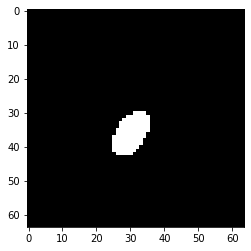

In [83]:
ind = np.random.choice(range(len(y_test)))
pred = model_saved(x_test[ind].view(-1,1,IMAGE_SIZE,IMAGE_SIZE).to(dev))
pred = torch.argmax(pred,dim=1)
print(pred[0].item(), '  ', y_test[ind].item())
plt.imshow(x_test[ind].reshape((IMAGE_SIZE, IMAGE_SIZE)), cmap="gray")
plt.show()